- 데이터셋
  - 트위터 메시지의 감정: 분노, 혐오, 두려움, 기쁨, 슬픔, 놀람의 6개 감정
- DistilBERT: BERT와 성능이 비슷하지만 작고 효율적임

In [1]:
from datasets import load_dataset

emotions = load_dataset('emotion', trust_remote_code=True)
emotions

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [2]:
train_ds = emotions['train']
print(train_ds[0], train_ds.column_names)
print(train_ds.features)
print(train_ds[:3])

{'text': 'i didnt feel humiliated', 'label': 0} ['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong'], 'label': [0, 0, 3]}


In [3]:
import pandas as pd
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head(3)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3


In [4]:
# 레이블이 정수로 출력되므로 feature 속성으로 레이블 이름 추가
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)
df['label_name'] = df['label'].apply(label_int2str)
df.head(3)

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger


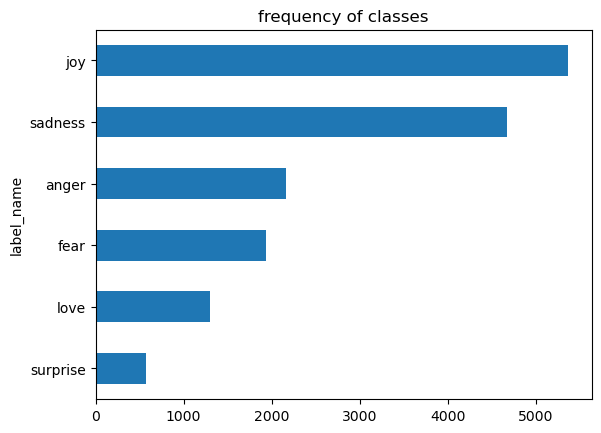

In [5]:
# 클래스 분포
import matplotlib.pyplot as plt
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('frequency of classes')
plt.show()

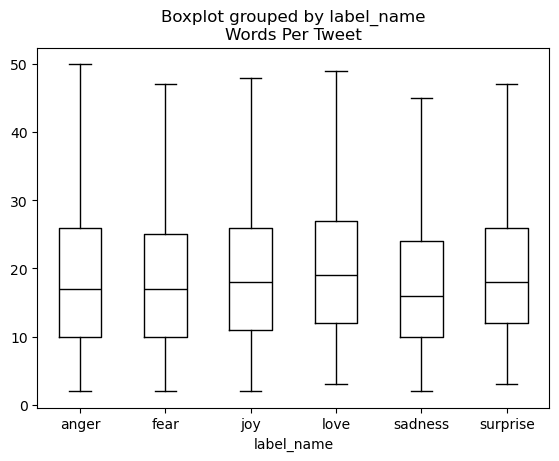

In [6]:
# 트윗 길이 확인. 트랜스포머는 최대 문맥 크기라는 최대 입력 시퀀스 길이가 있음.
# DistilBERT는 512토큰. 
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.show()

In [7]:
# dataframe 포맷이 필요하지 않으니 데이터셋의 출력 포맷 초기화
emotions.reset_format()

- 트랜스포머 모델은 텍스트가 토큰화되어 수치 벡터로 인코딩
- 토큰화: 문자열을 모델이 사용하는 기본 단위로 분할하는 단계

In [8]:
# 문자 토큰화
text = 'Tokenizing text is a core task of NLP.'
tokenized_text = list(text)
print(tokenized_text)

# numericalzation (수치화) 고유한 각 토큰을 고유한 정수로 인코딩
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

# vocabulary의 문자를 고유한 정수로 바꾸는 매핑 딕셔너리 생성
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

# input_ids -> 2D tensor 변환. one_hot()을 이용해 원-핫 인코딩
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
print(one_hot_encodings.shape)
print(f'token={tokenized_text[0]}')
print(f'tensor index={input_ids[0]}')
print(f'ont-hot encoding:{one_hot_encodings[0]}')

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']
{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}
[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]
torch.Size([38, 20])
token=T
tensor index=5
ont-hot encoding:tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [9]:
# 단어 토큰화. 간단하게는 공백으로 토큰화
# 문제점: 구두점 미고려, 곡용, 활용형, 철자 오류가 포함될 가능성
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [10]:
# 부분단어 토큰화. WordPiece. 
from transformers import AutoTokenizer
model_ckpt = 'distilbert-base-uncased'

# 체크포인트 이름을 사용해 모델의 설정, 가중치, 어휘사전을 자동으로 추출하는 자동클래스
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# DistilBERT 토크나이저를 로드하는 방법
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
# 토크나이저가 어떻게 동작하는지.
encoded_text = tokenizer(text)
print(encoded_text)

# input_ids -> 토큰으로 변환
# 1. [CLS], [SEP] 는 시퀀스 처음과 끝을 알려줌
# 2. 토큰이 모두 소문자로 변환됨
# 3. tokenizing, NLP가 두개의 토큰으로 나뉨. ##zing, ##p의 #는 앞 문자열이 공백을 아님을 뜻함
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))
# vocab size, 모델의 최대 문맥 크기, 모델이 정방향 패스에서 기대하는 필드 이름
print(tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']
[CLS] tokenizing text is a core task of nlp. [SEP]
30522 512 ['input_ids', 'attention_mask']


In [12]:
# 전체 데이터셋 토큰화하기

def tokenize(batch):
    # 샘플 토큰화할 처리함수
    # padding: 가장 긴 샘플 크기에 맞춰 0으로 패딩
    # truncation: 최대 문맥 크기에 맞춰 샘플 잘라냄
    return tokenizer(batch['text'], padding=True, truncation=True)

# input_ids의 첫번째가 두번째보다 짧으므로 길이를 동일하게 맞추기 위해 0 추가.
# 0은 [PAD] 토큰. 
# attention_mask: 모델이 입력에서 패딩된 부분을 무시함
print(tokenize(emotions['train'][:2]))

# map method는 모든 샘플에 개별 적용하므로 트윗을 배치로 인코딩함
# batch_size=None이므로 전체 데이터셋이 하나의 배치로 적용됨.
# 이렇게 하면 입력 텐서와 어텐션 마스크는 전역적으로 동일한 크기로 생성됨
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded['train'].column_names)

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


- 모델 훈련방법
  - 특성 추출: 사전 훈련된 모델을 수정하지 않고 은닉 상태를 feature로 사용해 훈련
    - 트랜스포머를 훈련하는 동안 바디의 가중치를 동결하고 은닉 상태를 분류 모델의 특성으로 사용
    - 작거나 얕은 모델을 빠르게 훈련한다는 장점
  - 미세 튜닝: 사전 훈련된 모델의 파라미터도 업데이트하기 위해 전체 모델을 end-to-end로 훈련

In [13]:
# AutoModel 클래스: 사전 훈련된 모델의 가중치를 로드
from transformers import AutoModel
model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

# 마지막 은닉 상태 추출
text = 'this is a test'
inputs = tokenizer(text, return_tensors='pt')
# [batch_size, n_tokens]
print(f"input tensor size={inputs['input_ids'].size()}")

inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

input tensor size=torch.Size([1, 6])
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [14]:
# 은닉 상태의 크기 확인
# 6개의 입력 토큰마다 768차원의 벡터가 반환됨.
# 분류 작업에서는 보통 [CLS] 토큰에 연관된 은닉 상태를 입력 특성으로 사용함
print(outputs.last_hidden_state.size()) # batch_size, n_tokens, hidden_dim
print(outputs.last_hidden_state[:,0].size())

# map을 이용해 모든 은닉 상태 추출
def extract_hidden_state(batch):
    # input을 gpu로 옮김
    inputs = {k: v.to(device) for k, v in batch.items() \
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태 추출
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [cls] token vector
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

# map method에 배치 입력을 사용하려면 파이썬이나 넘파이 객체를 반환하는 처리 함수가 필요
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# 모든 분할에 대해 은닉 상태 추출
emotions_hidden = emotions_encoded.map(extract_hidden_state, batched=True)
emotions_hidden['train'].column_names

torch.Size([1, 6, 768])
torch.Size([1, 768])


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [15]:
# feature vector
import numpy as np

x_train = np.array(emotions_hidden['train']['hidden_state'])
x_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
print(x_train.shape, x_valid.shape)

(16000, 768) (2000, 768)


In [16]:
# 시각화.
from sklearn import metrics
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정
x_scaled = MinMaxScaler().fit_transform(x_train)
# UMAP 객체를 생성하고 훈련함
mapper = UMAP(n_components=2, metric='cosine').fit(x_scaled)
# 2d 임베딩의 데이터프레임 만듦
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
print(df_emb.head(3))

fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f'label == {i}')
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'umap'

In [ ]:
# 트랜스포머 미세튜닝(end-to-end)
# 은닉 상태를 고정된 특성으로 사용하지 않고 전체 모델을 훈련함. 이를 위해 분류 헤드는 미분 가능해야함
# 1. 사전훈련된 DistilBERT 모델이 필요
# AutoModelForSequenceClassification모델은 사전훈련된 모델 출력 위에 베이스 모델과 함께
# 쉽게 훈련할 수 있는 분류 헤드가 있다는 점.
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels).to(device))

# 측정 지표 정의
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 훈련하기
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'~/.cache/huggingface/{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(
    output_dir=model_name, num_train_epochs=2, learning_rate=2e-5,
    per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size,
    weight_decay=0.01, evaluation_strategy='epoch', disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=False, save_strategy='epoch',
    load_best_model_at_end=True, log_level='error')

trainer = Trainer(
    model=model, args=training_args, compute_metrics=compute_metrics, 
    train_dataset=emotions_encoded['train'], eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer)
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.545622,0.810000,0.774203
2,0.739100,0.352960,0.899000,0.894942


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=250, training_loss=0.7390806274414062, metrics={'train_runtime': 59.8176, 'train_samples_per_second': 534.959, 'train_steps_per_second': 4.179, 'total_flos': 720342861696000.0, 'train_loss': 0.7390806274414062, 'epoch': 2.0})

In [ ]:
# 검증세트에 대한 예측
preds_output = trainer.predict(emotions_encoded['validation'])
print(preds_output.metrics)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.35295993089675903, 'test_accuracy': 0.899, 'test_f1': 0.8949419291510539, 'test_runtime': 1.2224, 'test_samples_per_second': 1636.134, 'test_steps_per_second': 13.089}


In [ ]:
# 오류분석
# 모델의 손실 기준으로 검증 샘플을 정렬. 정방향 패스의 결과와 레이블을 사용하면 손실 자동 계산
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')
    return {'loss': loss.cpu().numpy(), 'predicted_label': pred_label.cpu().numpy()}

# map method로 손실 계산
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
emotions_encoded['validation'] = emotions_encoded['validation'].map(
    forward_pass_with_label, batched=True, batch_size=16)

# dataframe 생성
emotions_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = (df_test['predicted_label'].apply(label_int2str))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# 손실 높은 샘플 확인
df_test.sort_values('loss', ascending=False).head(3)

,text,label,predicted_label,loss
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.715830
1963,i called myself pro life and voted for perry w...,joy,sadness,4.685395
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.609928


In [ ]:
# 파이프라인 테스트
from transformers import pipeline
model_id = 'transformersbook/distilbert-base-uncased-finetuned-emotion'
classifier = pipeline('text-classification', model=model_id)

custom_tweet = 'I saw a movie today and it was really good.'
preds = classifier(custom_tweet, return_all_scores=True)

preds_df = pd.DataFrame(prds[0])
plt.bar(labels, 100*preds_df['score'], color='C0')
plt.show()